In [1]:
import matplotlib.pyplot as plt
import numpy as np
from DynGenModels.trainer.trainer import DynGenModelTrainer

def plot_gaussians(data, num_points=None, title=None, xlim=(-5,5), ylim=(-5,5)):

    import scipy.stats as stats

    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

# Deconvolving 3 Perpendicular Gaussians: Normalizing flows

### inference without pre-processing:

#=================================================================================
INFO: created directory: ../results/MAF_RQS.smeared_gaussians_2023.10.02_18h44__1
#=================================================================================
+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| features            | ['x', 'y']                                      |
| data_name           | smeared_gaussians                               |
| num_points          | 60000                                           |
| dim_input           | 2                                               |
| noise_cov           | [[0.1, 0], [0, 1]]                              |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | x: [-2.0, 1.0]                                  |
|           

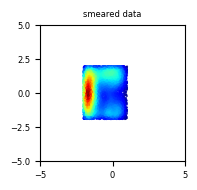

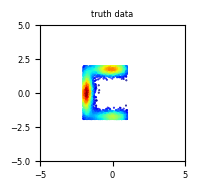

INFO: number of training parameters: 48630


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

	 test loss: -4.846805274486542  (min loss: -4.846805274486542)
	 test loss: -5.451842665672302  (min loss: -5.451842665672302)


In [6]:

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.deconvolution_configs import Deconvolution_Gauss_MAF_RQS_NormFlow as Configs

configs = Configs(data_name = 'smeared_gaussians',
                num_points = 60000,
                data_split_fracs = [0.8, 0.2, 0.0],
                noise_cov = [[0.1,0],[0,1]],
                cuts = {'x':[-2.0, 1.0], 
                        'y':[-1.9, 2.0]},
                preprocess=['normalize', 'logit_transform', 'standardize'],
                num_transforms=5,
                tail_bound=10,
                num_bins=20,
                batch_size = 256,
                epochs = 10,
                early_stopping = None,
                warmup_epochs = None,
                print_epochs = 5,
                lr = 1e-3,
                dim_hidden = 128, 
                device = 'cpu',
                seed = 12345,
                num_mc_draws = 30
               )

#...set working directory for results:

configs.set_workdir(path='../results', save_config=True)

from DynGenModels.datamodules.deconvolution.datasets import RectifiedSmearedGaussDataset
from DynGenModels.datamodules.deconvolution.dataloader import ToysDataLoader 
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS
from DynGenModels.dynamics.nf.deconvolution import DeconvolutionNormFlows

dataset = RectifiedSmearedGaussDataset(configs)
dataloader = ToysDataLoader(dataset, configs)
net = MAFPiecewiseRQS(configs)
dynamics = DeconvolutionNormFlows(net, configs)
maf = DynGenModelTrainer(dynamics, dataloader, configs)

plot_gaussians(dataset.smeared, title='smeared data', num_points=10000)
plot_gaussians(dataset.truth, title='truth data', num_points=10000)

maf.train()

We wish to recover the truth distribution $q(y)$ (left plots) given the smeared one $p(x)$ (middle plots) and the noise model assumed to be Gaussian. This is equivalkent to the deconvolution problem $x = y + \epsilon$:

$p(x) = q\star \mathcal{N}(x) = \int d\epsilon\, p(x-\epsilon)\mathcal{N}(0, \Sigma^2)$

we show two cases: (i) 3 perependicular gaussian distributions and, (ii) the same distributions but with hard edges corresponding to cuts. This last situtation is a toy model for Gaia data where all stars fall inside a ball of fixed radius $R$.

The plots in the last column show the results for a trained normalizing flow deconvolution. The case without cuts works well, one can see that the procedure is trying to unsmear the data back to the truth shape. When cuts are imposed the deconvolution does not work well becasue of the data discontinuities. For this reason we need to use preprocessing...



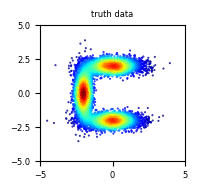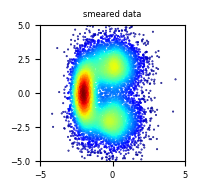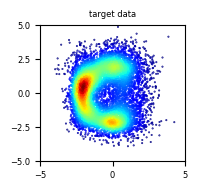

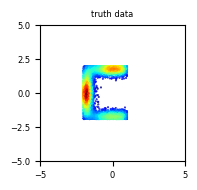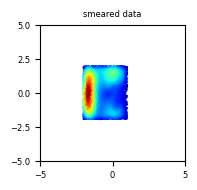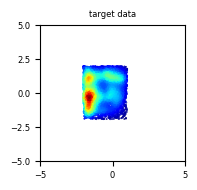

In [5]:
dataset.preprocess_methods

['normalize', 'logit_trasform', 'standardize']

INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


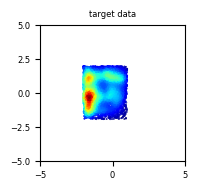

In [7]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.deconvolution.dataprocess import PostProcessGaussData

pipeline = NormFlowPipeline(trained_model=maf, configs=configs, num_gen_samples=10000, postprocessor=PostProcessGaussData)
plot_gaussians(pipeline.target, title='target data')


### Inference with preprocessing
The above deconvolution works pretty well... I run into issues when we decide to preprocess the data with non-linear fucntions

$\phi: x\to x^\prime$ 

The distroy the linearity $x = y+\epsilon$, i.e. the deinsity of $p(x^\prime)$ in the transfrimed space is no longer a convolution integral. One can see this explicitly in the results below:

INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


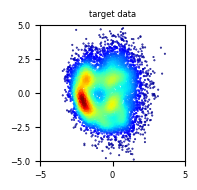

In [7]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.deconvolution.dataprocess import PostProcessGaussData

pipeline = NormFlowPipeline(trained_model=maf, configs=configs, num_gen_samples=10000, postprocessor=PostProcessGaussData)
plot_gaussians(pipeline.target, title='target data')


Even just a linear 'normalization' the results are ditorted... 

INFO: post-processing sampled data with ['inverse_normalize']


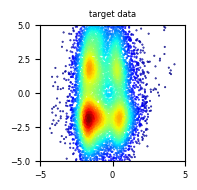

In [9]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.deconvolution.dataprocess import PostProcessGaussData

pipeline = NormFlowPipeline(trained_model=maf, configs=configs, num_gen_samples=10000, postprocessor=PostProcessGaussData)
plot_gaussians(pipeline.target, title='target data')

### Inference with preprocessing

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from DynGenModels.configs.toys_configs import Deconv_Gauss_MAF_RQS_NormFlow as Configs

configs = Configs(data_name = 'gauss_to_2moons',
                num_points = 20000,
                data_split_fracs = [0.8, 0.2, 0.0],
                noise_cov = [[0.1,0],[0,1]],
                preprocess=['normalize', 'logit_transform', 'standardize'],
                cuts = {'x':[-2.0, 1.0], 'y':[-np.inf, 2.0]},
                num_transforms=3,
                tail_bound=10,
                num_bins=20,
                batch_size = 256,
                epochs = 100,
                early_stopping = None,
                warmup_epochs = None,
                print_epochs = 20,
                lr = 1e-3,
                dim_hidden = 16, 
                device = 'cpu',
                seed = 12345
               )

#...set working directory for results:

configs.set_workdir(path='../results', save_config=True)

from DynGenModels.datamodules.toys.datasets import RectifiedSmearedGaussDataset
from DynGenModels.datamodules.toys.dataloader import ToysDataLoader 
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow

dataset = RectifiedSmearedGaussDataset(configs)
dataloader = ToysDataLoader(dataset, configs)
net = MAFPiecewiseRQS(configs)
dynamics = NormalizingFlow(net, configs)
maf = DynGenModelTrainer(dynamics, dataloader, configs)
maf.train()

ImportError: cannot import name 'Gauss_Deconv_Configs' from 'DynGenModels.datamodules.toys.configs' (/Users/dario/Dropbox/PROJECTS/ML/DynGenModels/src/DynGenModels/datamodules/toys/configs.py)

INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


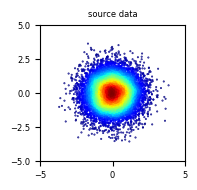

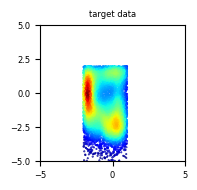

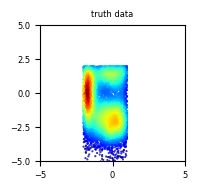

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.toys.dataprocess import PostProcessGaussData

pipeline = NormFlowPipeline(trained_model=maf, configs=configs, num_gen_samples=10000, postprocessor=PostProcessGaussData)

plot_gaussians(dataset.source, title='source data', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='target data')
plot_gaussians(dataset.target, title='truth data', num_points=len(pipeline.target))

# Deconvolution: Flow-Matching

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from DynGenModels.configs.utils import DynGenModelConfigs
from DynGenModels.trainer.trainer import DynGenModelTrainer

In [ ]:
from DynGenModels.datamodules.toys.configs import Gauss_Deconv_Configs
from DynGenModels.models.configs import MLP_Configs
from DynGenModels.dynamics.cnf.configs import CNF_Configs
from DynGenModels.pipelines.configs import NeuralODE_Sampler_Configs

Configs = DynGenModelConfigs(data = Gauss_Deconv_Configs,
                             model = MLP_Configs, 
                             dynamics = CNF_Configs, 
                             pipeline = NeuralODE_Sampler_Configs)

configs = Configs(data_name = 'smeared_gaussians',
                features = ['x', 'y'],
                num_points = 30000,
                sigma = 1e-6,
                noise_cov = [[0.1,0],[0,1]],
                data_split_fracs = [0.6, 0.1, 0.3],
                epochs = 300,
                early_stopping=1000,
                batch_size = 512,
                warmup_epochs = 50,
                print_epochs = 50,
                lr = 1e-3,
                dim_hidden = 16, 
                device = 'cpu',
                solver='midpoint',
                num_sampling_steps=1000,
                seed = 12345
                )
                
configs.set_workdir(path='../results', save_config=True)

#=============================================================================
INFO: created directory: ../results/MLP.smeared_gaussians_2023.09.28_19h24__1
#=============================================================================
+--------------------+--------------------+
| Key                | Value              |
+--------------------+--------------------+
| features           | ['x', 'y']         |
| data_name          | smeared_gaussians  |
| num_points         | 30000              |
| dim_input          | 2                  |
| noise_cov          | [[0.1, 0], [0, 1]] |
| device             | cpu                |
| data_split_fracs   | [0.6, 0.1, 0.3]    |
| batch_size         | 512                |
| epochs             | 300                |
| early_stopping     | 1000               |
| warmup_epochs      | 50                 |
| print_epochs       | 50                 |
| lr                 | 0.001              |
| seed               | 12345              |
| model_name    

In [ ]:
from DynGenModels.datamodules.toys.datasets import SmearedGaussDataset as DataSet
from DynGenModels.datamodules.toys.dataloader import ToysDataLoader as Loader

dataset = DataSet(configs)
dataloader = Loader(dataset, configs)

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.6/0.1/0.3
INFO: train size: 18000, validation size: 3000, testing sizes: 9000


In [ ]:
from DynGenModels.models.mlp import MLP
from DynGenModels.dynamics.cnf.deconvolution import DeconvolutionFlowMatching

mlp = MLP(configs)
cfm = DynGenModelTrainer(dynamics=DeconvolutionFlowMatching(mlp, configs), 
                         dataloader=dataloader,
                         configs=configs)

cfm.train()

INFO: number of training parameters: 642


epochs:   0%|          | 0/300 [00:00<?, ?it/s]

	 test loss: 0.0010236703157424927  (min loss: 0.0010236703157424927)
	 test loss: 0.000908848524093628  (min loss: 0.0008689931432406108)
	 test loss: 0.0008907763659954071  (min loss: 0.0008394133150577545)
	 test loss: 0.0008553609748681387  (min loss: 0.0008394133150577545)
	 test loss: 0.0009241629143555959  (min loss: 0.0008394133150577545)
	 test loss: 0.0009147012333075205  (min loss: 0.0008394133150577545)


In [ ]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline as Pipeline
pipeline = Pipeline(trained_model=cfm, configs=configs, num_sampling_steps=200)

sampling:   0%|          | 0/18 [00:00<?, ?it/s]

/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


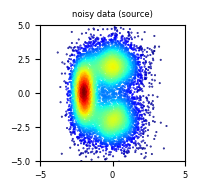

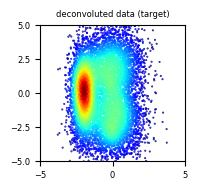

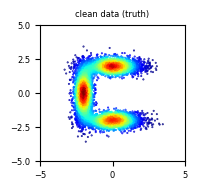

In [ ]:

def plot_gaussians(data, num_points=None, title=None):

    import scipy.stats as stats

    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()


plot_gaussians(dataset.source, title='noisy data (source)', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='deconvoluted data (target)')
plot_gaussians(dataset.truth, title='clean data (truth)', num_points=len(pipeline.target))

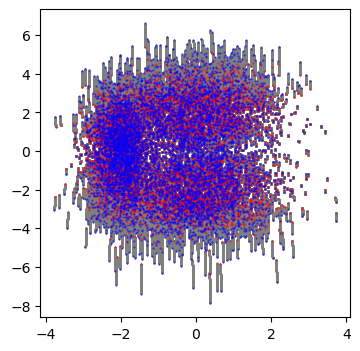

In [ ]:
#...plot trajectories:

num_points =10000
fig, ax = plt.subplots(1,1, figsize=(4,4))
for i in range(configs.num_sampling_steps): 
    plt.scatter(pipeline.trajectories[i][:num_points,0], pipeline.trajectories[i][:num_points,1], s=0.0225, color='gray', alpha=0.3)
plt.scatter(pipeline.trajectories[0][:num_points,0], pipeline.trajectories[0][:num_points,1], s=0.3, color='red', alpha=0.6)
plt.scatter(pipeline.trajectories[-1][:num_points,0], pipeline.trajectories[-1][:num_points,1], s=0.3, color='blue', alpha=0.6)
plt.show()

# Deconvolution Normalizing Flows

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from DynGenModels.trainer.trainer import DynGenModelTrainer

In [ ]:

from DynGenModels.configs.toys_configs import Deconv_Gauss_MAF_RQS_NormFlow as Configs


configs = Configs(data_name = 'smeared_gaussians',
                features = ['x', 'y'],
                num_points = 30000,
                noise_cov = [[0.1,0],[0,1]],
                data_split_fracs = [0.8, 0.19, 0.01],
                epochs = 10,
                early_stopping=30,
                batch_size = 256,
                warmup_epochs = 20,
                print_epochs = 10,
                lr = 5e-4,
                dim_hidden = 128, 
                device = 'cpu',
                seed = 12345,
                num_transforms = 2,
                num_gen_samples = 6000,
                num_mc_draws = 30
                )

configs.set_workdir(path='../results', save_config=True)

#=================================================================================
INFO: created directory: ../results/MAF_RQS.smeared_gaussians_2023.09.28_23h00__1
#=================================================================================
+---------------------+--------------------+
| Key                 | Value              |
+---------------------+--------------------+
| features            | ['x', 'y']         |
| data_name           | smeared_gaussians  |
| num_points          | 30000              |
| dim_input           | 2                  |
| noise_cov           | [[0.1, 0], [0, 1]] |
| device              | cpu                |
| data_split_fracs    | [0.8, 0.19, 0.01]  |
| batch_size          | 256                |
| epochs              | 10                 |
| early_stopping      | 30                 |
| warmup_epochs       | 20                 |
| print_epochs        | 10                 |
| lr                  | 0.0005             |
| seed                | 12345   

In [ ]:
from DynGenModels.datamodules.toys.datasets import SmearedGaussDataset
from DynGenModels.datamodules.toys.dataloader import ToysDataLoader

dataset = SmearedGaussDataset(configs)
dataloader = ToysDataLoader(dataset, configs)

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.19/0.01
INFO: train size: 24000, validation size: 5700, testing sizes: 300


In [ ]:
from DynGenModels.dynamics.nf.deconvolution import DeconvolutionNormFlows
from DynGenModels.models.maf import  MAFPiecewiseRQS

maf = MAFPiecewiseRQS(configs)
nflow = DynGenModelTrainer(dynamics=DeconvolutionNormFlows(maf, configs), 
                           dataloader=dataloader,
                           configs=configs)

nflow.train()

INFO: number of training parameters: 40890


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

	 test loss: 0.0011815134788814344  (min loss: 0.0011815134788814344)


In [ ]:
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline
pipeline = NormFlowPipeline(trained_model=nflow, configs=configs, num_gen_samples=6000)

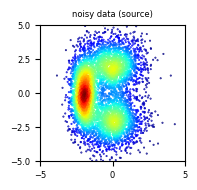

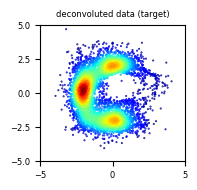

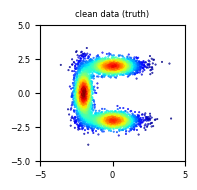

In [ ]:

def plot_gaussians(data, num_points=None, title=None):

    import scipy.stats as stats

    fig, ax = plt.subplots(1,1,figsize=(2,2))
    x = data[:num_points,0]
    y = data[:num_points,1]
    z = stats.gaussian_kde(np.vstack([x,y]))(np.vstack([x,y]))
    plt.scatter(x, y, c=z, s=0.2, cmap='jet')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.title(title, fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()


plot_gaussians(dataset.source, title='noisy data (source)', num_points=len(pipeline.target))
plot_gaussians(pipeline.target, title='deconvoluted data (target)')
plot_gaussians(dataset.truth, title='clean data (truth)', num_points=len(pipeline.target))